### COVID-19 OUTLIER DETECTION

Author: Jose Hernandez

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_circles
from sklearn.cluster import DBSCAN

In [130]:
sub = pd.read_csv('owid_covid_data.csv')
sub['date'] = pd.to_datetime(sub['date'])
mask = (sub['date'] >= '2020-04-01') & (sub['date'] <= '2023-04-30')
df_filtered = sub[mask].copy()

keep = [
    'location', 'continent', 'date',
    'total_cases', 'total_deaths',
    'gdp_per_capita', 'life_expectancy', 'population_density',
    'stringency_index', 'median_age',
    'hospital_beds_per_thousand', 'human_development_index', 'extreme_poverty',
    'new_cases' # needed temporarily for filtering
]

df_filtered = df_filtered[keep]
df_nonzero_cases = df_filtered[df_filtered['new_cases'] > 0].copy()
df_nonzero_cases = df_nonzero_cases.drop(columns=['new_cases'])
sub = df_nonzero_cases.sort_values(by=['location', 'date']).reset_index(drop=True)
sub = sub.dropna() # drop NaN

numerical_cols = [
    'total_cases', 'total_deaths', 'gdp_per_capita', 'life_expectancy',
    'population_density', 'stringency_index', 'median_age',
    'hospital_beds_per_thousand', 'human_development_index', 'extreme_poverty'
]

scaler = StandardScaler()
sub_scaled_numerical = pd.DataFrame(scaler.fit_transform(sub[numerical_cols]), columns=numerical_cols)
sub_scaled = pd.concat([sub[['location', 'continent', 'date']].reset_index(drop=True), sub_scaled_numerical], axis=1)
print(sub_scaled.head())

  location continent       date  total_cases  total_deaths  gdp_per_capita  \
0  Albania    Europe 2020-04-05    -0.297351     -0.338866       -0.351407   
1  Albania    Europe 2020-04-12    -0.297336     -0.338808       -0.351407   
2  Albania    Europe 2020-04-19    -0.297319     -0.338779       -0.351407   
3  Albania    Europe 2020-04-26    -0.297300     -0.338770       -0.351407   
4  Albania    Europe 2020-05-03    -0.297286     -0.338731       -0.351407   

   life_expectancy  population_density  stringency_index  median_age  \
0         0.738589           -0.164429          1.588105    0.743426   
1         0.738589           -0.164429          1.588105    0.743426   
2         0.738589           -0.164429          1.823255    0.743426   
3         0.738589           -0.164429          1.823255    0.743426   
4         0.738589           -0.164429          1.823255    0.743426   

   hospital_beds_per_thousand  human_development_index  extreme_poverty  
0                    0.0

    location continent       date  gdp_per_capita  stringency_index  anomaly  \
616  Algeria    Africa 2022-10-30       -0.227704         -1.981938       -1   
617  Algeria    Africa 2022-11-06       -0.227704         -1.981938       -1   
618  Algeria    Africa 2022-11-13       -0.227704         -1.981938       -1   
619  Algeria    Africa 2022-11-20       -0.227704         -1.981938       -1   
620  Algeria    Africa 2022-11-27       -0.227704         -1.981938       -1   

     is_anomaly  
616        True  
617        True  
618        True  
619        True  
620        True  


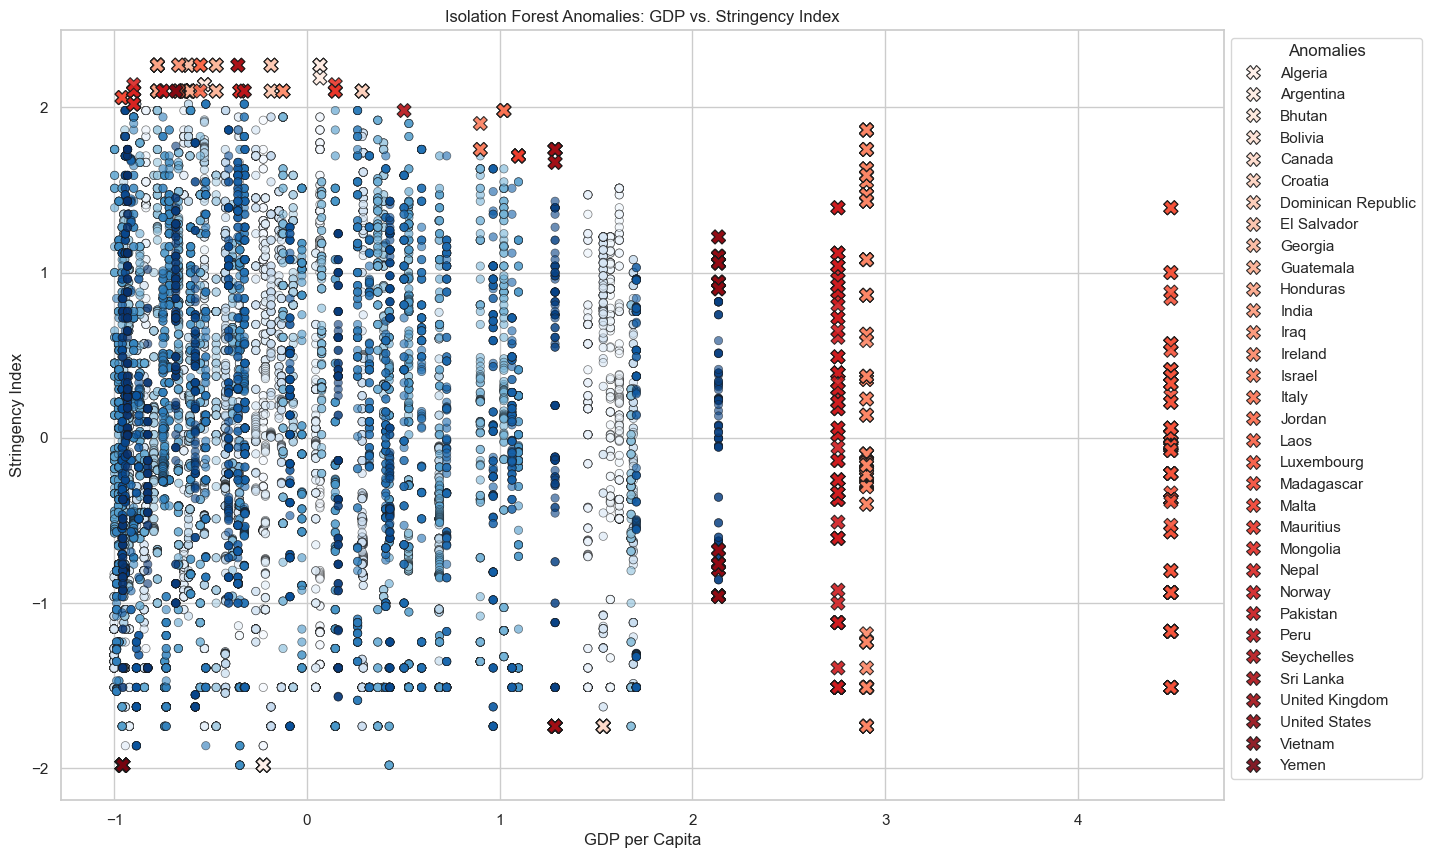

In [ ]:
features = ['gdp_per_capita', 'stringency_index']
X = sub_scaled_numerical[features]

# create isolation forest model
model = IsolationForest(n_estimators=200, contamination=0.05, random_state=0)
anomaly_labels = model.fit_predict(X)

# create results df with metadata
results = sub[['location', 'continent', 'date']].iloc[X.index].copy()
results['gdp_per_capita'] = sub_scaled_numerical['gdp_per_capita'].iloc[X.index].values
results['stringency_index'] = sub_scaled_numerical['stringency_index'].iloc[X.index].values
results['anomaly'] = anomaly_labels
results['is_anomaly'] = results['anomaly'] == -1
print(results[results['is_anomaly']].head())

# create scatter plot: points will be colored by country using 'hue' and assigned color palette
plt.figure(figsize=(15, 10))

sns.scatterplot(
    data=results[results['is_anomaly'] == False],
    x='gdp_per_capita',
    y='stringency_index',
    hue='location',
    palette='Blues',
    alpha=0.6,
    edgecolor='k',
    legend=False, 
    marker='o'
)

# anomaly points (colored by country and marked with 'x')
sns.scatterplot(
    data=results[results['is_anomaly'] == True],
    x='gdp_per_capita',
    y='stringency_index',
    hue='location',
    palette='Reds',
    alpha=0.9,
    edgecolor='k',
    marker='X',
    s=100
)

plt.title("Isolation Forest Anomalies: GDP vs. Stringency Index")
plt.legend(title="Anomalies", bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel("GDP per Capita")
plt.ylabel("Stringency Index")
plt.show()

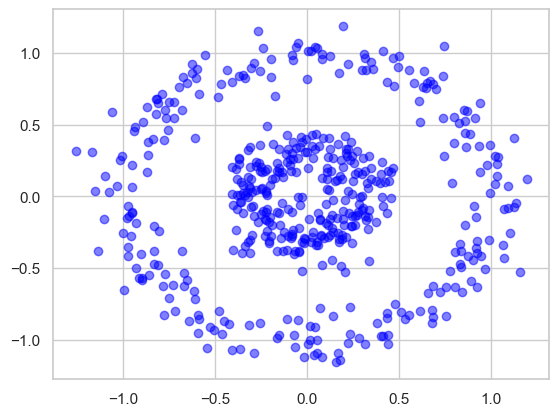

In [175]:
X, y = make_circles(n_samples=500, noise=0.1, factor=0.3, random_state=0)
plt.scatter(X[:, 0], X[:, 1], c='blue', alpha=0.5)


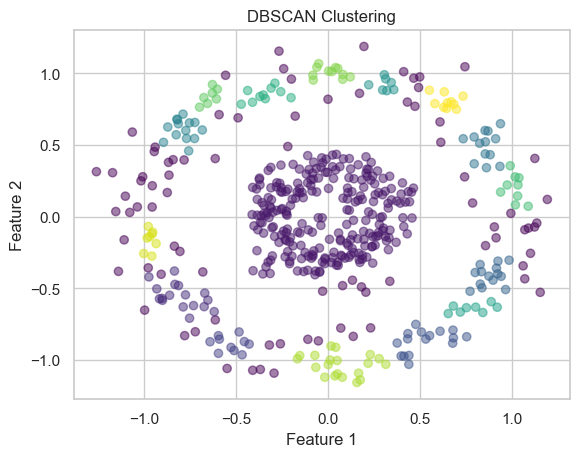

In [ ]:
dbscan = DBSCAN(eps=0.1, min_samples=5)
labels = dbscan.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.title("DBSCAN Clustering")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()